# Processing Sequences Using RNNs and CNNs

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Basic RNNs

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)


In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


In [5]:
print(X_train.shape)
print(y_train.shape)


(7000, 50, 1)
(7000, 1)


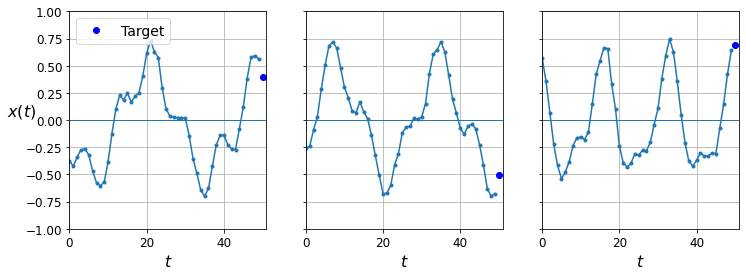

In [8]:
def plot_series(
    series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True
):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(
        X_valid[col, :, 0],
        y_valid[col, 0],
        y_label=("$x(t)$" if col == 0 else None),
        legend=(col == 0),
    )

plt.show()


## Computing Some Baselines

In [10]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

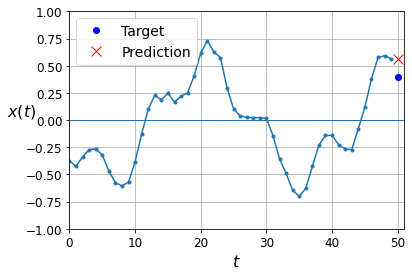

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()


#### Linear predictions

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[50, 1]),
        keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 997us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 988us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 990us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 996us/step - loss: 0.0061 - val_loss

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 775us/step - loss: 0.0042


0.004168087150901556

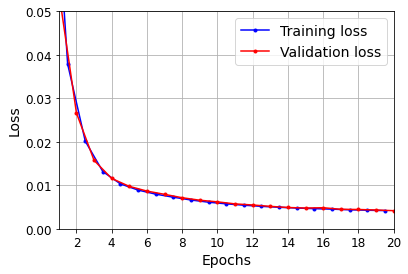

In [15]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


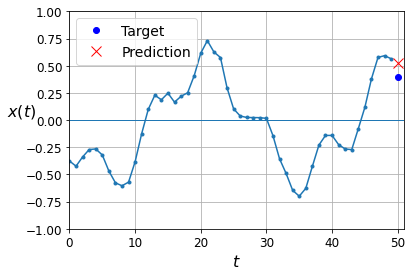

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()


## Using a Simple RNN

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0116 - val_lo

In [18]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0113


0.011268764734268188

## Deep RNNs

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 13s 55ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 14s 62ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 19s 87ms/step - loss: 0.003

In [21]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 19ms/step - loss: 0.0030


0.003034037770703435

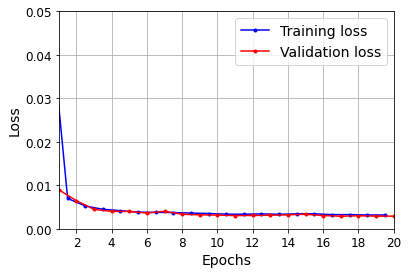

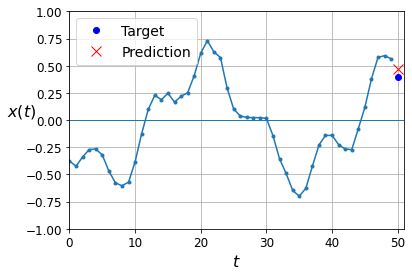

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()


In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 11s 47ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0030 - va

In [24]:
model.evaluate(X_test, y_test)


32/32 [==============================] - 0s 12ms/step - loss: 0.0028


0.002761571668088436

### Forecasting Several Steps Ahead

In [28]:
np.random.seed(43)  # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    # Add the new predict value to the inputs (acting as if this predicted value had actually occured!)
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]


In [29]:
print(Y_pred)
print(Y_pred.shape)

[[[ 5.9786546e-01]
  [ 6.2769639e-01]
  [ 5.8462006e-01]
  [ 4.4361216e-01]
  [ 2.5026211e-01]
  [-2.0542461e-04]
  [-2.2154382e-01]
  [-3.9917144e-01]
  [-4.9649718e-01]
  [-5.1475245e-01]]]
(1, 10, 1)


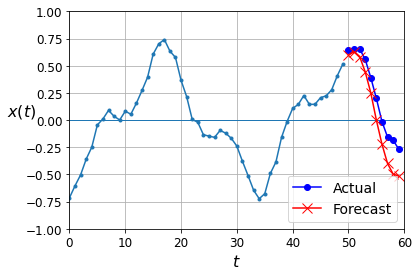

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(
        np.arange(n_steps, n_steps + ahead),
        Y_pred[0, :, 0],
        "rx-",
        label="Forecast",
        markersize=10,
    )
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Use this model to predict the next 10 values

In [38]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]


In [39]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]


In [40]:
print(Y_pred.shape)

(2000, 10)


In [41]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))


0.027510846

In [42]:
Y_naive_pred = np.tile(
    X_valid[:, -1], 10
)  # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))


0.25697407

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(10)]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0222

Create an RNN that predicts all 10 values at once

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(10),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 8s 33ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0110 - val_lo

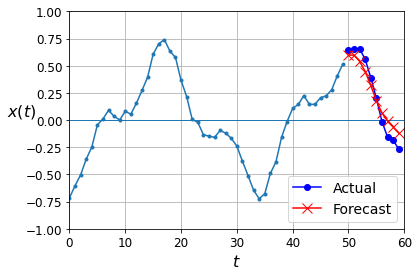

In [45]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Create an RNN that predicts next 10 steps at each time step!
This model is causal: When it makes predictions at any time step, it only see past time steps.

In [46]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_steps, 0]
Y_train = Y[:7000]  # 7000 points are used for training
Y_valid = Y[7000:9000]  # 2000 points are used for validation
Y_test = Y[9000:]  # 1000 points are used to test


In [47]:
print(X_train.shape)
print(Y_train.shape)

(7000, 50, 1)
(7000, 50, 10)


In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10)),
    ]
)


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[last_time_step_mse],
)
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 14s 59ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0365 - val_last_time_step_mse: 0.0263
Epoch 3/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0323 - last_time_step_mse: 0.0212 - val_loss: 0.0317 - val_last_time_step_mse: 0.0212
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0295 - last_time_step_mse: 0.0182 - val_loss: 0.0276 - val_last_time_step_mse: 0.0156
Epoch 5/20
219/219 [==============================] - 13s 60ms/step - loss: 0.0273 - last_time_step_mse: 0.0154 - val_loss: 0.0285 - val_last_time_step_mse: 0.0203
Epoch 6/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0254 - last_time_step_mse: 0.0130 - val_loss: 0.0250 - val_last_time_step_mse: 0.0120
Epoch 7/20
219/2

In [51]:
np.random.seed(43)

# Only one copy of 50 + 10 samples
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
# I'm not sure how to use np.newaxis...
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


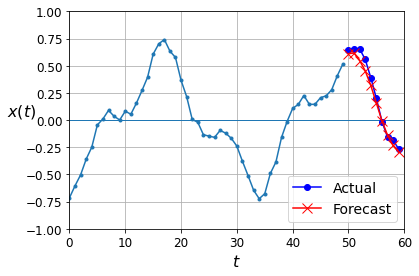

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


In [65]:
array = np.array([1, 2, 3, 4])
print(array)
assert array.shape == (4,)

array = array[np.newaxis]
print(array)
assert array.shape == (1, 4)

array = np.array([1, 2, 3, 4])
assert array.shape == (4,)
array = array[:, np.newaxis]
print(array)
assert array.shape == (4, 1)


[1 2 3 4]
[[1 2 3 4]]
[[1]
 [2]
 [3]
 [4]]


## Deep RNN with Batch Norm

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.TimeDistributed(keras.layers.Dense(10)),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 15s 62ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

## Deep RNNs with Layer Norm

In [69]:
from tensorflow.keras.layers import LayerNormalization